## Basic packages

In [4]:
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import os,sys

import copy

import h3

import folium

import branca.colormap as cmp

from shapely.geometry import Point, Polygon

import math

import geopandas as gp

import random


import time


import datetime

## Basic Functions

In [5]:
'''Get travel distance'''

def Get_distance(point1,point2):
    
    return Point(point1).distance(Point(point2))*111000*1.2

'''Get travel time'''

def Get_travel_time(dis,speed):
    
    return int(dis/speed)

'''Filter Zones'''

def Get_POLYGON(coords):
    if coords.type=='Polygon':
        return coords
    else:
        Score={i:coords[i].area for i in range(len(coords))}
        idx=max(Score, key=Score.get)
        return coords[idx]
    
'''Randomly Generate nodes'''

def Generate_Point(location,Zone_geometry):
    
    Poly=Zone_geometry[location]
    
    coordinates=list(Poly.exterior.coords)
    
    lngs=[x[0] for x in coordinates]
    
    lats=[x[1] for x in coordinates]
    
    lng_min,lng_max=min(lngs),max(lngs)
    
    lat_min,lat_max=min(lats),max(lats)
    
    lat=random.random()*(lat_max-lat_min)+lat_min
    
    lng=random.random()*(lng_max-lng_min)+lng_min
    
    pnt=Point(lng,lat)
    
    while Poly.contains(pnt)!=True:
        
        lat=random.random()*(lat_max-lat_min)+lat_min
    
        lng=random.random()*(lng_max-lng_min)+lng_min
    
        pnt=Point(lng,lat)
        
    return [lat,lng]

'''Week Transfer'''

def get_week_day(date):
    
    date=datetime.datetime.strptime(date, '%Y-%m-%d')
    
    week_day_dict = {
    0 : 'MON',
    1 : 'TUE',
    2 : 'WED',
    3 : 'THU',
    4 : 'FRI',
    5 : 'SAT',
    6 : 'SUN',
    }
    day = date.weekday()
    
    return week_day_dict[day]
        

## Basic Parameters

In [6]:
'''Param'''

resolution = 9

s_sec=25200

e_sec=36000

speed=20000/360

Driver_num=3000

'''Load data'''

'''Grid-related data'''

Grid_list=np.load('./Data/NYC_Network/Grids.npy',allow_pickle=True)


'''Point-related data'''

Points_list=np.load('./Data/NYC_Network/Points_list.npy',allow_pickle=True)

Link_Point=np.load('./Data/NYC_Network/Link_Point.npy',allow_pickle=True).item()

Point_coordinate=np.load('./Data/NYC_Network/Point_coordinate.npy',allow_pickle=True).item()

Point_Grid=np.load('./Data/NYC_Network/Point_Grid.npy',allow_pickle=True).item()

## Spatial Filtering

In [17]:

'''1. Dividing NYC to Zones'''

Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data=Zone_data[['borough','zone','geometry','location_i']]

Zone_data=Zone_data.loc[Zone_data['borough']=='Manhattan']

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry','location_i']]

Islands=['Zone_19','Zone_20','Zone_21','Zone_38','Zone_47','Zone_48']

# Islands=['Zone_19','Zone_20','Zone_21']

Zone_data=Zone_data.loc[~Zone_data['Zone_id'].isin(Islands)]

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data['geometry']=Zone_data.apply(lambda x:Get_POLYGON(x['geometry']),axis=1)

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data=Zone_data.rename(columns={'location_i':'LocationID'})

Zone_data[['LocationID']] = Zone_data[['LocationID']].astype(float)

Zone_data['type']=Zone_data.apply(lambda x:x['geometry'].type,axis=1)


Zone_geometry={}

for idx,row in Zone_data.iterrows():
    
    Zone_geometry[row['LocationID']]=row['geometry']


'''Zones candidates'''


Locations=Zone_data['LocationID'].tolist()


'''Background'''

background = folium.Map([40.769602, -73.973667],tiles='CartoDB positron',zoom_start=12)

'''Zones'''

folium.Choropleth(
    geo_data=Zone_data[['geometry']],
    fill_color='blue',
    fill_opacity=0.5,
    name='Zone').add_to(background)


folium.LayerControl().add_to(background)

background

## Generate Daily data

In [12]:
GetStamp=lambda x:time.mktime(time.strptime(x,'%Y-%m-%d %H:%M:%S'))

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

Order_df=pd.read_csv('./Data/NYC_2020/yellow_tripdata_2020-12.csv')

Order_df=Order_df[['tpep_pickup_datetime','PULocationID','DOLocationID']]

# Order_df=Order_df.loc[(Order_df['PULocationID'].isin(Locations))&(Order_df['DOLocationID'].isin(Locations))]

Order_df['date']=Order_df.apply(lambda x:x['tpep_pickup_datetime'][0:10],axis=1)

Order_df['Arrive_stamp']=Order_df.apply(lambda x:GetStamp(x['tpep_pickup_datetime']),axis=1)

Order_df['Order_id'] = ['O'+str(i) for i in Order_df.index]

Order_df['Driver_id'] = 'Waiting'

Start_step=2520 # Start stamp 

End_step=3600 # End stamp 

Order_Num={}

for dt in Dates:
    
    order_df=copy.deepcopy(Order_df.loc[Order_df['date']==dt])
    
    base_line=GetStamp(dt+' 00:00:00')
    
    order_df['Arrive_second']=order_df.apply(lambda x:int(x['Arrive_stamp']-base_line),axis=1)
    
    order_df['Arrive_step']=order_df.apply(lambda x:int(x['Arrive_second']/10),axis=1)
    
    order_df=order_df.loc[(order_df['Arrive_step']>=Start_step)&(order_df['Arrive_step']<End_step)]
    
    
    
    
    
#     order_df['Response_step']=3600*24
    
#     order_df['Pickup_step']=3600*24
    
#     order_df['Pickup_Point']=order_df.apply(lambda x:Generate_Point(x['PULocationID'],Zone_geometry),axis=1)

#     order_df['Dropoff_Point']=order_df.apply(lambda x:Generate_Point(x['DOLocationID'],Zone_geometry),axis=1)

#     order_df['Pickup_Latitude']=order_df.apply(lambda x:x['Pickup_Point'][0],axis=1)

#     order_df['Pickup_Longitude']=order_df.apply(lambda x:x['Pickup_Point'][1],axis=1)

#     order_df['Dropoff_Latitude']=order_df.apply(lambda x:x['Dropoff_Point'][0],axis=1)

#     order_df['Dropoff_Longitude']=order_df.apply(lambda x:x['Dropoff_Point'][1],axis=1)

#     order_df['Pickup_Grid']=order_df.apply(lambda x:h3.geo_to_h3(x['Pickup_Latitude'],x['Pickup_Longitude'],resolution),axis=1)

#     order_df['Dropoff_Grid']=order_df.apply(lambda x:h3.geo_to_h3(x['Dropoff_Latitude'],x['Dropoff_Longitude'],resolution),axis=1)
    
#     order_df=order_df.loc[order_df['Pickup_Grid'].isin(Grid_list)]
    
#     order_df=order_df.loc[order_df['Dropoff_Grid'].isin(Grid_list)]
     
#     order_df['Travel_dis']=order_df.apply(lambda x:Get_distance(x['Pickup_Point'],x['Dropoff_Point']),axis=1)
    
#     order_df['Travel_time']=order_df.apply(lambda x:int(Get_travel_time(x['Travel_dis'],speed)),axis=1)
    
#     order_df=order_df[['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
#    'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
#    'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
#    'Dropoff_Point', 'Travel_dis', 'Travel_time','date']]
    
#     order_df.to_csv('./Data/NYC_2020/Order_df_'+str(dt)+'.csv')
    
    print('Date: ',dt,'The number of orders: ',order_df.shape[0])
    
    Order_Num[dt]=order_df.shape[0]


order_df
    
    

Date:  2020-12-01 The number of orders:  8189
Date:  2020-12-02 The number of orders:  8602
Date:  2020-12-03 The number of orders:  8556
Date:  2020-12-04 The number of orders:  7902
Date:  2020-12-05 The number of orders:  3544
Date:  2020-12-06 The number of orders:  2727
Date:  2020-12-07 The number of orders:  8534
Date:  2020-12-08 The number of orders:  9156
Date:  2020-12-09 The number of orders:  9246
Date:  2020-12-10 The number of orders:  9055
Date:  2020-12-11 The number of orders:  8036
Date:  2020-12-12 The number of orders:  3589
Date:  2020-12-13 The number of orders:  2632
Date:  2020-12-14 The number of orders:  9544
Date:  2020-12-15 The number of orders:  9327
Date:  2020-12-16 The number of orders:  9912
Date:  2020-12-17 The number of orders:  2008
Date:  2020-12-18 The number of orders:  8594
Date:  2020-12-19 The number of orders:  3915
Date:  2020-12-20 The number of orders:  2664
Date:  2020-12-21 The number of orders:  7736
Date:  2020-12-22 The number of or

,tpep_pickup_datetime,PULocationID,DOLocationID,date,Arrive_stamp,Order_id,Driver_id,Arrive_second,Arrive_step
1322826,2020-12-31 07:10:16,145,145,2020-12-31,1.609370e+09,O1322826,Waiting,25816,2581
1322827,2020-12-31 07:11:50,145,145,2020-12-31,1.609370e+09,O1322827,Waiting,25910,2591
1322828,2020-12-31 07:19:52,145,145,2020-12-31,1.609370e+09,O1322828,Waiting,26392,2639
1322829,2020-12-31 07:25:08,143,143,2020-12-31,1.609371e+09,O1322829,Waiting,26708,2670
1322830,2020-12-31 07:25:34,145,145,2020-12-31,1.609371e+09,O1322830,Waiting,26734,2673
...,...,...,...,...,...,...,...,...,...
1459296,2020-12-31 09:12:23,265,121,2020-12-31,1.609377e+09,O1459296,Waiting,33143,3314
1459297,2020-12-31 09:12:09,265,130,2020-12-31,1.609377e+09,O1459297,Waiting,33129,3312
1459298,2020-12-31 09:12:30,265,35,2020-12-31,1.609377e+09,O1459298,Waiting,33150,3315
1459299,2020-12-31 09:48:00,237,217,2020-12-31,1.609379e+09,O1459299,Waiting,35280,3528


In [13]:
9327+9912+7736+7784

34759

In [14]:
34759/4

8689.75

In [15]:
8689.75-7644.5

1045.25

## Weekday and Weekend Plotting

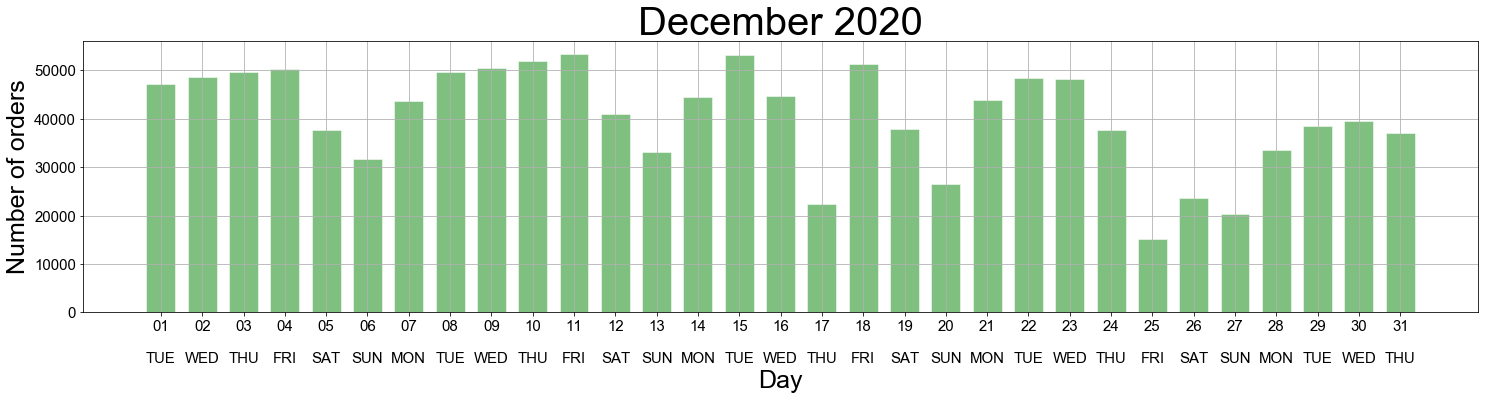

In [20]:
'''Plot Figure'''

figsize = 25,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]


ax1.bar(range(len(Order_Num)),\
        list(Order_Num.values()),\
        bottom=[0 for i in range(len(Order_Num))],
        width = 0.7,\
        alpha=0.5,\
        facecolor = 'green',\
        edgecolor = 'white')
    


ax1.set_ylabel('Number of orders',font_label)

ax1.set_xlabel('Day',font_label)



# ax1.set_xlim([0.5,14.5])

xmajorLocator   = MultipleLocator(1)

ax1.xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(10000)

ax1.yaxis.set_major_locator(ymajorLocator1)

xticks = [str(dt[-2:])+'\n\n'+get_week_day(dt) for dt in Dates]

plt.xticks(range(len(Order_Num)), xticks)

plt.grid()

ax1.set_title('December 2020',font_title)

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('./Real_World/Month_Demand.eps', format='eps', dpi=1000, bbox_inches = 'tight')

current_fig.savefig('./Real_World/Month_Demand.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

plt.show()


## Travel Distance

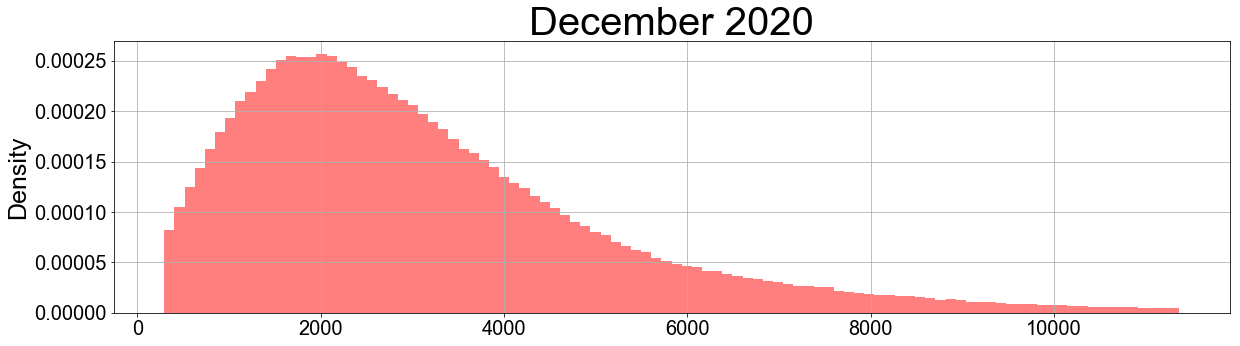

In [21]:
'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
    if len(Weekdays)>10:
        
        break
        
'''Merge data'''

Order_DF=pd.DataFrame([],columns=['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
   'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
   'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
   'Dropoff_Point', 'Travel_dis', 'Travel_time','date'],dtype=object)
        
for dt in Weekdays:
    
    Order_df=pd.read_csv('./Data/NYC_2020/Order_df_'+str(dt)+'.csv')

    Order_df=Order_df.drop(columns=['Unnamed: 0'])
    
    Order_DF=pd.concat([Order_DF,Order_df],ignore_index=True)

Array=copy.deepcopy(np.array(Order_DF['Travel_dis'].to_list()))

Array.sort()

min_ = Array[int(0.01 * len(Array))]

max_ = Array[int(0.99 * len(Array))]
    
Array = Array[int(0.01 * len(Array)):int(0.99 * len(Array))+1]




'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)


labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Arial') for label in labels]

'''Plot'''

Y, X, l1 =ax1.hist(Array,\
          bins=100,\
          facecolor='r',\
          label='Real-world observation',\
          density=True,\
          alpha=0.5)


ax1.grid()

ax1.set_ylabel('Density',font_label)

# ax1[0].set_xlim([0,70000])

ax1.set_title('December 2020',font_title)

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('./Real_World/Travel_distance.eps', format='eps', dpi=1000, bbox_inches = 'tight')

current_fig.savefig('./Real_World/Travel_distance.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

plt.show()



## Hourly Demand

In [ ]:
'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
    if len(Weekdays)>10:
        
        break
        
'''Merge data'''

Order_DF=pd.DataFrame([],columns=['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
   'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
   'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
   'Dropoff_Point', 'Travel_dis', 'Travel_time','date'],dtype=object)
        
for dt in Weekdays:
    
    Order_df=pd.read_csv('./Data/NYC_2020/Order_df_'+str(dt)+'.csv')

    Order_df=Order_df.drop(columns=['Unnamed: 0'])
    
    Order_DF=pd.concat([Order_DF,Order_df],ignore_index=True)
    
    
'''Statistics'''

def Get_minute(step):
    
    return int(step/6)


Order_STAT=Order_DF.groupby(['Arrive_step']).count()

Order_STAT['Step']=Order_STAT.index

Order_STAT=Order_STAT.reset_index(drop=True)

Order_STAT=Order_STAT.rename(columns={'Order_id':'Order_num'})

Order_STAT['Order_num']=Order_STAT.apply(lambda x:x['Order_num']/len(Weekdays),axis=1)

Order_STAT=Order_STAT[['Step','Order_num']]

Order_STAT['minute']=Order_STAT.apply(lambda x:Get_minute(x['Step']),axis=1)

Order_STAT=Order_STAT.groupby('minute').sum()

Order_STAT['minute']=Order_STAT.index

Order_STAT=Order_STAT.reset_index(drop=True)

Order_STAT["Cumulative_orders"]=0


for idx,col in Order_STAT.iterrows():
    
    if idx!=0:
    
        Order_STAT.loc[idx,'Cumulative_orders']=Order_STAT.loc[idx-1,'Cumulative_orders']+Order_STAT.loc[idx,'Order_num']
        
    else:
        
        Order_STAT.loc[idx,'Cumulative_orders']=Order_STAT.loc[idx,'Order_num']
        

Order_STAT=Order_STAT[['minute','Order_num','Cumulative_orders']]

Order_STAT
    
        


In [ ]:
'''Plot Figure'''


X_labels=['','']

for h in range(25):
    
    if h<10:
        
        X_labels.append('0'+str(h))
        
    else:
        
        X_labels.append(str(h))
        
        

figsize = 20,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(2,1,figsize=figsize)

for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
    
    

'''Plot'''

cumulative=[0  for i in list(Order_STAT['minute'])]

ax1[0].bar(Order_STAT['minute'],\
        Order_STAT['Order_num'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'g',\
        label='Arriving orders per minute')
    


xmajorLocator   = MultipleLocator(60)

ax1[0].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(50)

ax1[0].yaxis.set_major_locator(ymajorLocator1)

ax1[0].set_ylabel('Numbers',font_label)

ax1[0].grid()
        

ax1[0].set_xticklabels(X_labels,font_legend)




cumulative=[0  for i in list(Order_STAT['minute'])]

ax1[1].bar(Order_STAT['minute'],\
        Order_STAT['Cumulative_orders'],\
        bottom=cumulative,\
        width = 0.7,\
        facecolor = 'b',\
        label='Cumulative orders')
    



xmajorLocator   = MultipleLocator(60)

ax1[1].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(50000)

ax1[1].yaxis.set_major_locator(ymajorLocator1)

ax1[1].set_ylabel('Numbers',font_label)

ax1[1].set_xlabel('Hour',font_label)

ax1[1].grid()

ax1[1].set_xticklabels(X_labels,font_legend)


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.05),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('./Real_World/Hour_Demand.eps', format='eps', dpi=1000, bbox_inches = 'tight')

current_fig.savefig('./Real_World/Hour_Demand.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')

plt.show()

## Demand Distribution

In [4]:
'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
    if len(Weekdays)>10:
        
        break
        
'''Merge data'''


Start_step=2520 # Start stamp 

End_step=3600 # End stamp 


Order_DF=pd.DataFrame([],columns=['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
   'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
   'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
   'Dropoff_Point', 'Travel_dis', 'Travel_time','date'],dtype=object)
        
for dt in Weekdays:
    
    Order_df=pd.read_csv('./Data/NYC_2020/Order_df_'+str(dt)+'.csv')

    Order_df=Order_df.drop(columns=['Unnamed: 0'])
    
    Order_df=Order_df.loc[(Order_df['Arrive_step']>=Start_step)&(Order_df['Arrive_step']<End_step)]
    
    Order_DF=pd.concat([Order_DF,Order_df],ignore_index=True)
    
Order_DF

# '''Statistics'''

# def Get_minute(step):
    
#     return int(step/6)


# Order_STAT=Order_DF.groupby(['Arrive_step']).count()

# Order_STAT['Step']=Order_STAT.index

# Order_STAT=Order_STAT.reset_index(drop=True)

# Order_STAT=Order_STAT.rename(columns={'Order_id':'Order_num'})

# Order_STAT['Order_num']=Order_STAT.apply(lambda x:x['Order_num']/len(Weekdays),axis=1)

# Order_STAT=Order_STAT[['Step','Order_num']]

# Order_STAT['minute']=Order_STAT.apply(lambda x:Get_minute(x['Step']),axis=1)

# Order_STAT=Order_STAT.groupby('minute').sum()

# Order_STAT['minute']=Order_STAT.index

# Order_STAT=Order_STAT.reset_index(drop=True)

# Order_STAT["Cumulative_orders"]=0


# for idx,col in Order_STAT.iterrows():
    
#     if idx!=0:
    
#         Order_STAT.loc[idx,'Cumulative_orders']=Order_STAT.loc[idx-1,'Cumulative_orders']+Order_STAT.loc[idx,'Order_num']
        
#     else:
        
#         Order_STAT.loc[idx,'Cumulative_orders']=Order_STAT.loc[idx,'Order_num']
        

# Order_STAT=Order_STAT[['minute','Order_num','Cumulative_orders']]

# Order_STAT
    

,Order_id,Driver_id,Arrive_step,Response_step,Pickup_step,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Pickup_Grid,Dropoff_Grid,Pickup_Point,Dropoff_Point,Travel_dis,Travel_time,date,Waiting_time
0,O957,Waiting,2564,86400,86400,40.764325,-73.968438,40.765128,-73.953046,892a100d68fffff,892a100d443ffff,"[40.76432548777108, -73.96843811239191]","[40.7651284393302, -73.95304647969043]",2052.953349,205,2020-12-01,36.0
1,O958,Waiting,2618,86400,86400,40.768252,-73.952215,40.752985,-73.975691,892a100d453ffff,892a100d62bffff,"[40.76825154072153, -73.9522146204502]","[40.75298485865107, -73.9756913356094]",3730.141647,373,2020-12-01,22.0
2,O959,Waiting,2784,86400,86400,40.791020,-73.947695,40.813385,-73.937019,892a1008d2bffff,892a100ab73ffff,"[40.79102009551072, -73.9476954533909]","[40.8133851163646, -73.93701861983163]",3301.073681,330,2020-12-01,25.0
3,O960,Waiting,2862,86400,86400,40.798966,-73.945184,40.817824,-73.936776,892a1008d03ffff,892a100ab0bffff,"[40.798966376403456, -73.94518364450568]","[40.81782448626757, -73.93677601330062]",2750.238336,275,2020-12-01,37.0
4,O1659,Waiting,2520,86400,86400,40.767898,-73.976731,40.754397,-73.988483,892a100d6c3ffff,892a10725a7ffff,"[40.76789806148766, -73.97673133857616]","[40.75439683259448, -73.98848271240804]",2384.160819,238,2020-12-01,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85308,O1410638,Waiting,3474,86400,86400,40.747417,-73.976305,40.764190,-73.953767,892a100d297ffff,892a100d443ffff,"[40.747416635603834, -73.97630469619287]","[40.764189672088186, -73.95376679994979]",3742.165092,374,2020-12-15,39.0
85309,O1410642,Waiting,3301,86400,86400,40.705604,-74.018929,40.764049,-73.982060,892a107281bffff,892a100d643ffff,"[40.70560428249261, -74.01892854101244]","[40.76404937724983, -73.98206023324977]",9204.400678,920,2020-12-15,39.0
85310,O1410644,Waiting,3426,86400,86400,40.803066,-73.933314,40.804120,-73.942961,892a1008d97ffff,892a1008dc7ffff,"[40.80306560352497, -73.9333140249461]","[40.80412038714584, -73.94296102365925]",1292.638250,129,2020-12-15,31.0
85311,O1410658,Waiting,3524,86400,86400,40.775750,-73.955784,40.772493,-73.962766,892a1008933ffff,892a100892bffff,"[40.77575027564841, -73.95578438970048]","[40.7724926083356, -73.9627657999608]",1026.180317,102,2020-12-15,35.0


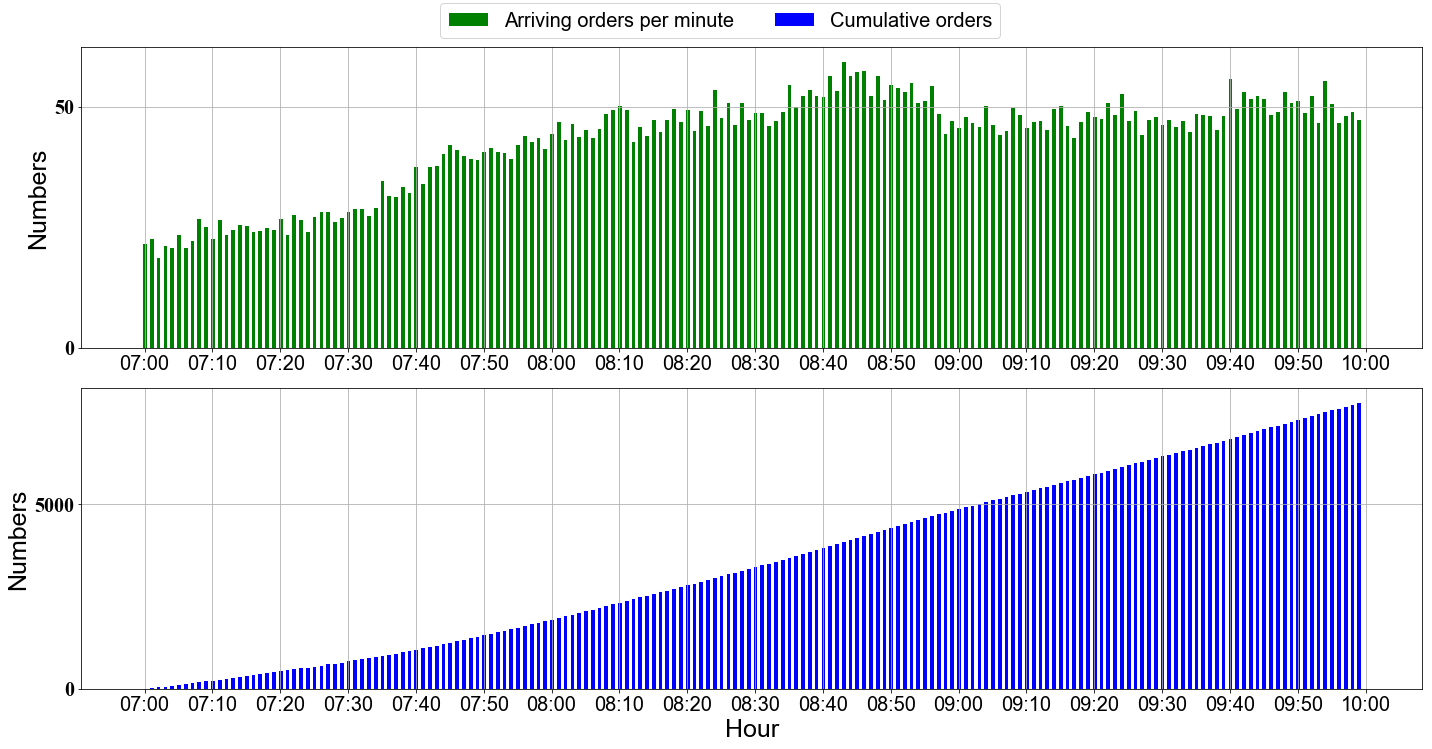

In [6]:
'''Plot Figure'''

figsize = 20,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(2,1,figsize=figsize)

for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
    
    

'''Plot'''

cumulative=[0  for i in list(Order_STAT['minute'])]

ax1[0].bar(Order_STAT['minute'],\
        Order_STAT['Order_num'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'g',\
        edgecolor = 'white',\
        label='Arriving orders per minute')
    


xmajorLocator   = MultipleLocator(10)

ax1[0].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(50)

ax1[0].yaxis.set_major_locator(ymajorLocator1)

ax1[0].set_ylabel('Numbers',font_label)

ax1[0].grid()

ax1[0].set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


cumulative=[0  for i in list(Order_STAT['minute'])]

ax1[1].bar(Order_STAT['minute'],\
        Order_STAT['Cumulative_orders'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'b',\
        edgecolor = 'white',\
        label='Cumulative orders')
    


xmajorLocator   = MultipleLocator(10)

ax1[1].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(5000)

ax1[1].yaxis.set_major_locator(ymajorLocator1)

ax1[1].set_ylabel('Numbers',font_label)

ax1[1].set_xlabel('Hour',font_label)

ax1[1].grid()

ax1[1].set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.05),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('./Real_World/Demand.eps', format='eps', dpi=1000, bbox_inches = 'tight')


plt.show()


## Heatmap

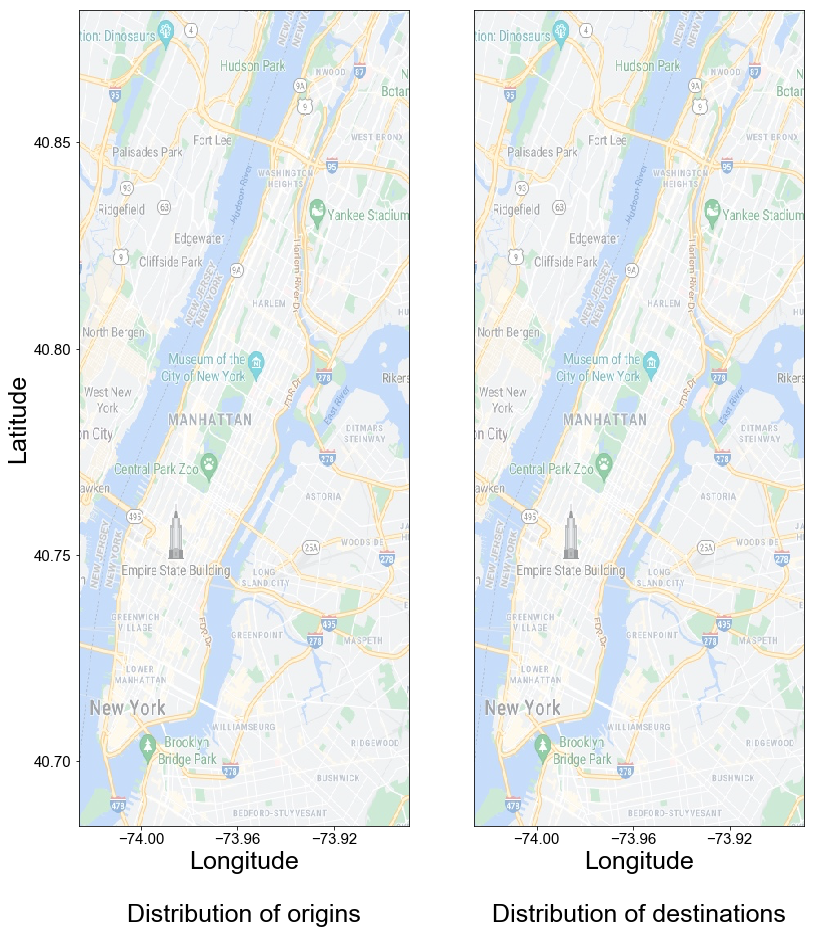

In [135]:
Southwest=[40.684289, -74.025695]

Northeast=[40.882081, -73.889064]

Map_path='./Data/Map/'

font_title = {'family' : 'Arial','weight' : 'normal','size': 25}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

tags=['\n\nDistribution of origins','\n\nDistribution of destinations']


def Background(area,sw,ne):
    
    bg_path=Map_path+area+'.png'
    
    img = plt.imread(bg_path)
    
    figsize = 13,15
    
    figure, ax1 = plt.subplots(1,2,figsize=figsize)
    
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    
    for i in range(2):

        labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

        [label.set_fontsize(15) for label in labels]

        [label.set_fontname('Arial') for label in labels]
        
        ax1[i].set_xlim(xgrange)
        
        ax1[i].set_ylim(ygrange)
        
        x0,x1 = ax1[i].get_xlim()
        
        y0,y1 = ax1[i].get_ylim()
    
        ax1[i].imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)
        
        ax1[i].set_xlabel('Longitude'+tags[i],font_label)
        
        xmajorLocator   = MultipleLocator(0.04)

        ax1[i].xaxis.set_major_locator(xmajorLocator)

        if i>0:
        
            ax1[i].set_yticks([])
            
        else:
            
            ax1[i].set_ylabel('Latitude',font_label)
            
            ymajorLocator1   = MultipleLocator(0.05)

            ax1[i].yaxis.set_major_locator(ymajorLocator1)
    
    return figure, ax1


figure, ax1=Background('NYC',Southwest,Northeast)





In [137]:
Origin_STAT=Order_DF.groupby(['Pickup_Grid']).count()

Origin_STAT['Grid']=Origin_STAT.index

Origin_STAT=Origin_STAT.reset_index(drop=True)

Origin_STAT=Origin_STAT.rename(columns={'Order_id':'Order_Num'})

Origin_STAT=Origin_STAT[['Grid','Order_Num']]

Origin_STAT['Order_Num']=Origin_STAT.apply(lambda x:x['Order_Num']/len(Weekdays),axis=1)

Origin_STAT['ratio']=Origin_STAT.apply(lambda x:(x['Order_Num']-min(Origin_STAT['Order_Num']))/(max(Origin_STAT['Order_Num'])-min(Origin_STAT['Order_Num'])),axis=1)



Destination_STAT=Order_DF.groupby(['Dropoff_Grid']).count()

Destination_STAT['Grid']=Destination_STAT.index

Destination_STAT=Destination_STAT.reset_index(drop=True)

Destination_STAT=Destination_STAT.rename(columns={'Order_id':'Order_Num'})

Destination_STAT=Destination_STAT[['Grid','Order_Num']]

Destination_STAT['Order_Num']=Destination_STAT.apply(lambda x:x['Order_Num']/len(Weekdays),axis=1)

Destination_STAT['ratio']=Destination_STAT.apply(lambda x:(x['Order_Num']-min(Destination_STAT['Order_Num']))/(max(Destination_STAT['Order_Num'])-min(Destination_STAT['Order_Num'])),axis=1)



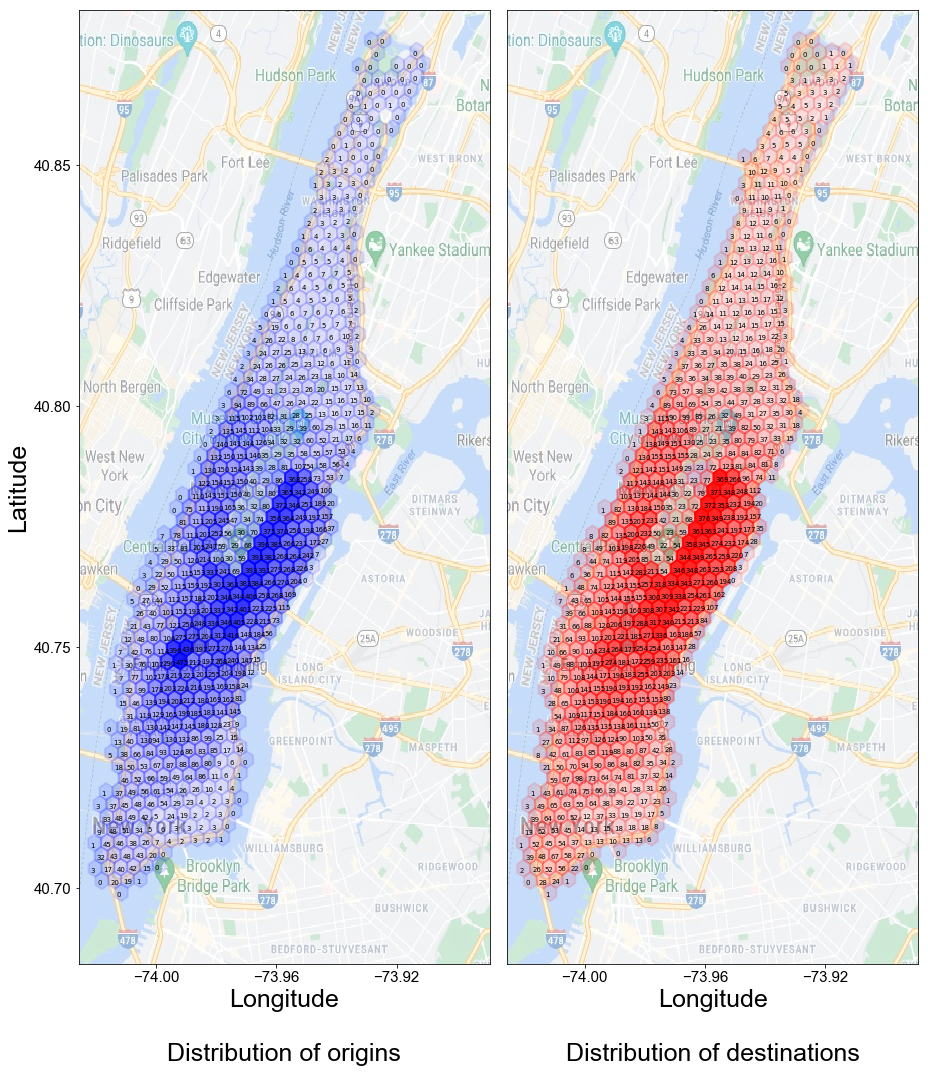

In [138]:
'''Heatmap'''

figure, ax1=Background('NYC',Southwest,Northeast)


    
    
'''Heatmap'''

for idx,row in Origin_STAT.iterrows():
    
    grid=row['Grid']
    
    ratio=row['ratio']
    
    num=int(row['Order_Num'])
    
    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='blue',linewidth=2,fill=True,alpha=0.8*ratio+0.1)

    ax1[0].add_patch(pgon)
    
    coordinates=h3.h3_to_geo(grid)

    ax1[0].annotate(s=str(num),fontsize=7,xy=(1.00002*coordinates[1],0.99998*coordinates[0]))
    
    
'''Heatmap'''

for idx,row in Destination_STAT.iterrows():
    
    grid=row['Grid']
    
    ratio=row['ratio']
    
    num=int(row['Order_Num'])
    
    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='red',linewidth=2,fill=True,alpha=0.8*ratio+0.1)

    ax1[1].add_patch(pgon)
    
    coordinates=h3.h3_to_geo(grid)

    ax1[1].annotate(s=str(num),fontsize=7,xy=(1.00002*coordinates[1],0.99998*coordinates[0]))
    
    

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('./Real_World/Heatmap.png', format='png',bbox_inches = 'tight')

plt.show()

## Waiting time

In [5]:
'''Week Transfer'''

def get_week_day(date):
    
    date=datetime.datetime.strptime(date, '%Y-%m-%d')
    
    week_day_dict = {
    0 : 'MON',
    1 : 'TUE',
    2 : 'WED',
    3 : 'THU',
    4 : 'FRI',
    5 : 'SAT',
    6 : 'SUN',
    }
    day = date.weekday()
    
    return week_day_dict[day]
        

In [6]:
Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
Weekdays

['2020-12-01',
 '2020-12-02',
 '2020-12-03',
 '2020-12-04',
 '2020-12-07',
 '2020-12-08',
 '2020-12-09',
 '2020-12-10',
 '2020-12-11',
 '2020-12-14',
 '2020-12-15',
 '2020-12-16',
 '2020-12-17',
 '2020-12-18',
 '2020-12-21',
 '2020-12-22',
 '2020-12-23',
 '2020-12-24',
 '2020-12-25',
 '2020-12-28',
 '2020-12-29',
 '2020-12-30',
 '2020-12-31']

In [7]:
import scipy.stats as stats

Daily_path='./Data/NYC_2020/'


Minute=6


'''Pick up patience'''

Mean_pickup=5*6

Min_pickup=3*6

Max_pickup=7*6

Waiting_pickup=2*6

'''Matching patience'''

Mean_match=5

Min_match=3

Max_match=7

Waiting_match=2

def Truncated_Gauss(mu,sigma,lower,upper,num):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return [round(x,0) for x in X.rvs(num)]


for day in Weekdays:

    Order_df=pd.read_csv(os.path.join(Daily_path,'Order_df_'+str(day)+'.csv'))

    Order_df=Order_df.drop(columns=['Unnamed: 0'])
    
    Order_num=Order_df.shape[0]
    
    Pick_up_patience=Truncated_Gauss(Mean_pickup,Waiting_pickup,Min_pickup,Max_pickup,Order_num)
    
    Matching_patience=Truncated_Gauss(Mean_match,Waiting_match,Min_match,Max_match,Order_num)
    
    Order_df['Pick_up_patience']=Pick_up_patience
    
    Order_df['Matching_patience']=Matching_patience
    
    Order_df.to_csv(os.path.join(Daily_path,'Order_df_'+str(day)+'.csv'))
    
Order_df

,Order_id,Driver_id,Arrive_step,Response_step,Pickup_step,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Pickup_Grid,Dropoff_Grid,Pickup_Point,Dropoff_Point,Travel_dis,Travel_time,date,Pick_up_patience,Matching_patience
0,O1320456,Waiting,19,86400,86400,40.766910,-73.982506,40.769530,-73.952203,892a100d653ffff,892a100d4cbffff,"[40.76691009189954, -73.98250619360118]","[40.769529944043505, -73.9522032681471]",4051.406515,72,2020-12-31,29.0,6.0
1,O1320879,Waiting,2,86400,86400,40.726403,-73.994739,40.761450,-73.959338,892a1072c8fffff,892a100d6b3ffff,"[40.72640276191237, -73.99473912575762]","[40.76145014005685, -73.9593382078987]",6635.370668,119,2020-12-31,27.0,5.0
2,O1320996,Waiting,8,86400,86400,40.756380,-73.971015,40.773620,-73.943935,892a100d63bffff,892a100d4d3ffff,"[40.756380012575704, -73.97101520105906]","[40.773620095839824, -73.94393472200518]",4276.057793,76,2020-12-31,22.0,5.0
3,O1321041,Waiting,177,86400,86400,40.752450,-73.977004,40.755579,-73.966578,892a100d62bffff,892a100d6afffff,"[40.752449972852105, -73.97700408015949]","[40.75557922418371, -73.96657760265742]",1450.006947,26,2020-12-31,30.0,4.0
4,O1321044,Waiting,84,86400,86400,40.751347,-73.995344,40.754444,-73.964900,892a1072537ffff,892a100d6afffff,"[40.75134670706877, -73.99534428135419]","[40.754443907738676, -73.96490022017306]",4076.079996,73,2020-12-31,37.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37097,O1461874,Waiting,8482,86400,86400,40.801387,-73.969095,40.750959,-74.008495,892a100888fffff,892a1072567ffff,"[40.80138683441016, -73.96909475625638]","[40.75095851088486, -74.00849535247306]",8524.199326,153,2020-12-31,37.0,4.0
37098,O1461875,Waiting,8562,86400,86400,40.727027,-73.981240,40.705228,-74.019041,892a100d343ffff,892a107280bffff,"[40.72702739548694, -73.98123998260553]","[40.70522769571589, -74.01904065420196]",5812.341432,104,2020-12-31,25.0,4.0
37099,O1461879,Waiting,8382,86400,86400,40.866444,-73.916636,40.709063,-74.014976,892a100a123ffff,892a10728c7ffff,"[40.86644429434548, -73.91663580986207]","[40.709062747834366, -74.01497568079157]",24719.164486,444,2020-12-31,24.0,5.0
37100,O1461886,Waiting,8298,86400,86400,40.769320,-73.961888,40.770561,-73.985726,892a100d693ffff,892a1008b23ffff,"[40.7693199341243, -73.96188756237213]","[40.77056147078842, -73.98572563662957]",3179.535052,57,2020-12-31,38.0,7.0
